This is a list of all the libraries that are used in this analysis

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, silhouette_score
import numpy as np
from scipy.stats import pearsonr, percentileofscore

Right now the data is imported from two excels which have advanced stats and player totals for the season. This will probably chance in the furture to getting data from basketball-reference.com. I also need to merge the two dataframes and remove duplicates. The duplicates occur when a player is traded from one team to another in the middle of the season.

In [8]:
df_advanced = pd.read_excel('Advanced Stats.xlsx')
df_total_stats = pd.read_excel('Total Stats.xlsx')
df = df_advanced.merge(df_total_stats, on = ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'Rk'])
df.drop_duplicates(['Player'], keep='first',inplace=True)

I am going to make a copy of the original df since I will remove some columns (Player name, position, team, age etc.) as they aren't important for analysis. I will need the player name later on to see which players cluster together. There are also some columns with NAs which I will drop as well as players with total time played less than 1000  minutes.

In [9]:
df.dropna(axis=1,inplace=True)
idx = df.index[df['MP']<1000]
df.drop(idx,inplace=True)
idx_gp = df.index[df['G']<50]
df.drop(idx_gp,inplace=True)
df_copy = df.copy(deep=True)
df.drop(['Pos', 'Rk', 'Tm', 'Player'],axis=1,inplace=True)

I am going to split the data into a train/test set. Since I want to keep a track of the training data in the original data frame, I will create a dummy array and split it then use those indices to split the dataframe.

In [10]:
indices = np.arange(0,np.shape(df)[0])
indices_train, indices_test  = train_test_split(indices, test_size=0.0)
train_df = df.iloc[indices_train,:]
test_df = df.iloc[indices_test,:]
train_df_copy = df_copy.iloc[indices_train,:]
test_df_copy = df_copy.iloc[indices_test,:]

Since there are 37 features, Ill use PCA for dimensionality reduction. But first, the data needs to be standardized

In [11]:
scaler = preprocessing.StandardScaler()
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df),columns=df.columns)

/anaconda2/envs/Py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/envs/Py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For PCA we need to determine the number of compopnents. Here, I used the explained variance ratio to determine the number of components

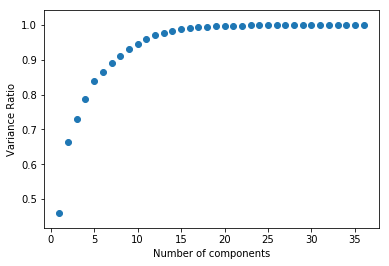

In [12]:
evr = []
for components in range(1, np.shape(train_df_scaled)[1]):
    pca = PCA(n_components=components)
    pca.fit(train_df_scaled)
    if components == 1:
        evr.append(pca.explained_variance_ratio_[-1])
    else:
        evr.append(evr[-1]+pca.explained_variance_ratio_[-1])

plt.scatter(np.arange(1,np.shape(df)[1]),evr)
plt.xlabel('Number of components')
plt.ylabel('Variance Ratio')
plt.show()
#     kmeans = KMeans(n_clusters=n_cluster,random_state=1).fit(X_train)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(X_train, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

Seems like 16 is a good number of components to use. Now we can check the correlation between the principal components and the original features.

Next, we need to determine the number of clusters. We can do this by using the Silhouette Measure and Elbow Method.

For n_clusters=2, The Silhouette Coefficient is 0.32847493288997265
For n_clusters=3, The Silhouette Coefficient is 0.2927403407481235
For n_clusters=4, The Silhouette Coefficient is 0.19556418547519586
For n_clusters=5, The Silhouette Coefficient is 0.20558860331477874
For n_clusters=6, The Silhouette Coefficient is 0.15267800976792167
For n_clusters=7, The Silhouette Coefficient is 0.16490519394024405
For n_clusters=8, The Silhouette Coefficient is 0.12312925422287288
For n_clusters=9, The Silhouette Coefficient is 0.12807295558060589
For n_clusters=10, The Silhouette Coefficient is 0.11708242488405685
For n_clusters=11, The Silhouette Coefficient is 0.11507074875720885
For n_clusters=12, The Silhouette Coefficient is 0.11438315898182826
For n_clusters=13, The Silhouette Coefficient is 0.11923031038937257
For n_clusters=14, The Silhouette Coefficient is 0.11931933925203989
For n_clusters=15, The Silhouette Coefficient is 0.11212235091134759
For n_clusters=16, The Silhouette Coefficie

No handles with labels found to put in legend.


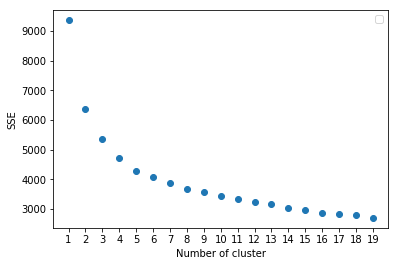

In [13]:
pca = PCA(n_components=15)
reduced_features = pca.fit_transform(train_df_scaled)

for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(reduced_features)
    label = kmeans.labels_
    sil_coeff = silhouette_score(reduced_features, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(reduced_features)
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.xticks(list(sse.keys()))
plt.legend()
plt.show()

Its a bit hard to interprety the silhouette measure but using the elbow method shows that 13 clusters is a good choice. Now to see what players are grouped together in our clusters

In [14]:
kmeans = KMeans(n_clusters=11).fit(reduced_features)
labels = kmeans.labels_ 
train_df_copy['labels'] = labels
names = {}
unique_labels = list(set(labels))
for i in range(len(unique_labels)):
    names[i] = train_df_copy[train_df_copy['labels']==unique_labels[i]]['Player']

/anaconda2/envs/Py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
original_centers = {}

for i in range(len(kmeans.cluster_centers_)):
    original_centers[i] = scaler.inverse_transform(np.dot(kmeans.cluster_centers_[i], pca.components_))

percentiles = {}
for i in range(len(kmeans.cluster_centers_)):
    percentiles[i] = []
    for j in range(len(kmeans.cluster_centers_[0])):
        percentiles[i].append(percentileofscore(kmeans.cluster_centers_[:,j],kmeans.cluster_centers_[i,j]))
    
display(percentiles)

array(['Age', 'G', 'MP', 'PER', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'GS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype=object)

{0: array([ 2.86123443e+01,  6.74740217e+01,  1.41706482e+03,  1.11253407e+01,
         3.51133105e+00,  1.26785754e+01,  8.13143467e+00,  9.05504144e+00,
         1.22910476e+00,  1.33715528e+00,  1.49890424e+01,  1.22365263e+00,
         1.30254110e+00,  2.52227297e+00,  8.47634510e-02, -8.64643477e-01,
        -4.38687428e-01, -1.30931890e+00,  2.35182962e-01,  1.47748208e+01,
         1.65086017e+02,  3.79452725e+02,  8.17604900e+01,  2.21617532e+02,
         8.33255269e+01,  1.57835193e+02,  5.33805914e+01,  6.94782934e+01,
         4.46374878e+01,  1.66666938e+02,  2.11304426e+02,  7.91151639e+01,
         3.48665611e+01,  2.26608811e+01,  4.44064409e+01,  1.26546444e+02,
         4.65313115e+02]),
 1: array([ 2.83155658e+01,  7.77372791e+01,  2.83322230e+03,  2.42482301e+01,
         2.35477673e+00,  1.51107214e+01,  8.76299517e+00,  2.77894182e+01,
         1.80906338e+00,  1.28801356e+00,  3.17716033e+01,  7.16170510e+00,
         2.96270488e+00,  1.01231192e+01,  1.86118727e-

NameError: name 'st' is not defined

In [41]:
cols = df.columns.tolist()
corr_coeff = np.zeros((np.shape(reduced_features)[1],np.shape(train_df_scaled)[1]))
corr = {}
for i in range(np.shape(reduced_features)[1]):
    corr[i] = []
    for j in range(np.shape(train_df_scaled)[1]):
        corr_coeff[i,j] = pearsonr(train_df_scaled.iloc[:,j],reduced_features[:,i])[0]
        if (corr_coeff[i,j] >= 0.4) or (corr_coeff[i,j] <= -0.4):
            corr[i].append(cols[j])
            
display(corr)
display(corr_coeff)

{0: ['MP',
  'PER',
  'DRB%',
  'TRB%',
  'AST%',
  'USG%',
  'OWS',
  'DWS',
  'WS',
  'WS/48',
  'OBPM',
  'DBPM',
  'BPM',
  'VORP',
  'GS',
  'FG',
  'FGA',
  '2P',
  '2PA',
  'FT',
  'FTA',
  'ORB',
  'DRB',
  'TRB',
  'AST',
  'STL',
  'BLK',
  'TOV',
  'PF',
  'PTS'],
 1: ['ORB%',
  'DRB%',
  'TRB%',
  'AST%',
  'BLK%',
  'USG%',
  'DBPM',
  'FGA',
  '3P',
  '3PA',
  'ORB',
  'TRB',
  'AST',
  'BLK',
  'PTS'],
 2: ['STL%', 'USG%', 'DBPM', 'STL'],
 3: ['G', 'MP', 'OBPM', 'PF'],
 4: ['AST%', 'STL%', '3P'],
 5: ['Age'],
 6: ['G'],
 7: [],
 8: [],
 9: ['G', 'GS'],
 10: ['PF'],
 11: [],
 12: [],
 13: [],
 14: []}

array([[-2.55003967e-02,  3.43472512e-01,  7.41319348e-01,
         8.85479354e-01,  3.83665493e-01,  5.35436785e-01,
         5.15376872e-01,  4.30505774e-01,  2.37565176e-01,
         3.32389484e-01,  6.38627530e-01,  8.18064101e-01,
         7.63157518e-01,  8.97767303e-01,  7.33898530e-01,
         7.39798672e-01,  4.70799291e-01,  8.40646824e-01,
         8.91817745e-01,  6.58106707e-01,  8.76984358e-01,
         7.79367458e-01,  2.25568801e-01,  2.38166668e-01,
         8.82808759e-01,  8.43727920e-01,  8.26499694e-01,
         8.57688613e-01,  6.01338170e-01,  8.24549638e-01,
         8.02719497e-01,  5.90921238e-01,  5.92837375e-01,
         5.50467979e-01,  7.83005751e-01,  5.88857378e-01,
         8.59831732e-01],
       [-1.21682204e-01, -7.30207322e-02, -3.81011429e-01,
         1.38842636e-01,  8.15133400e-01,  6.70425089e-01,
         7.73974359e-01, -5.29736372e-01, -6.19270040e-02,
         7.35023520e-01, -4.55199719e-01,  2.23428641e-02,
         2.51793717e-01,  1.10